In [351]:
import csv
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

In [352]:
DS = pd.read_csv("ObjectSubset150SentenceLength.csv")

In [353]:
DS['tag'].fillna('text', inplace=True)

In [354]:
words = list(set(DS["word"].values))
n_words = len(words)
tags = list(set(DS["tag"].values))
n_tags = len(tags)


In [355]:
tags

['text', 'object']

In [356]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("text_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]

getter = SentenceGetter(DS)
sentences = getter.sentences


In [357]:
labels = [[s[1] for s in sent] for sent in sentences]
sentences = [" ".join([s[0] for s in sent]) for sent in sentences]
sentences[0]


'26.05.09 patsient hospitaliseeritud erütrotsüütide ülekandeks, 2 doosi RR 120/85 temperatuur 37.7. Võetud vereanalüüsid. Enesetunne rahuldav.'

In [363]:
print(labels[0])


['text', 'text', 'text', 'text', 'text', 'text', 'text', 'object', 'object', 'text', 'text', 'text', 'text', 'text', 'text']


In [358]:
# from collections import Counter
from keras.preprocessing.sequence import pad_sequences

# word_cnt = Counter(DS["word"].values)
# vocabulary = set(w[0] for w in word_cnt.most_common(5000))


In [449]:
max_len = 150
word2idx = {w: i + 2 for i, w in enumerate(words)}

word2idx["UNK"] = 1
word2idx["PAD"] = 0
tags2 = ["PAD","text","object"]
tag2idx = {t: i for i, t in enumerate(tags2)}
# tag2idx["PAD"] = 0


In [450]:
tag2idx

{'PAD': 0, 'text': 1, 'object': 2}

In [451]:
idx2word = {i: w for w, i in word2idx.items()}

In [452]:
X = [[word2idx.get(w, word2idx["PAD"]) for w in s.split()] for s in sentences]


In [453]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["PAD"],truncating="post")


In [454]:
y = [[tag2idx[l_i] for l_i in l] for l in labels]


In [455]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["PAD"],truncating="post")


In [456]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=2018)


In [457]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional


In [458]:
word_input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 2, output_dim=20, input_length=max_len)(word_input)
model = SpatialDropout1D(0.3)(model)
model = Bidirectional(LSTM(units=20, return_sequences=True, recurrent_dropout=0.5))(model)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(model)


In [459]:
model = Model(word_input, out)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [460]:
history = model.fit(X_tr, y_tr.reshape(*y_tr.shape, 1),
                    batch_size=32, epochs=10,
                    validation_split=0.1, verbose=1)


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9822 samples, validate on 1092 samples
Epoch 1/10
9822/9822 [==============================] - 40s 4ms/step - loss: 0.1694 - accuracy: 0.9585 - val_loss: 0.0440 - val_accuracy: 0.9901
Epoch 2/10
9822/9822 [==============================] - 41s 4ms/step - loss: 0.0370 - accuracy: 0.9902 - val_loss: 0.0266 - val_accuracy: 0.9909
Epoch 3/10
9822/9822 [==============================] - 41s 4ms/step - loss: 0.0203 - accuracy: 0.9930 - val_loss: 0.0125 - val_accuracy: 0.9962
Epoch 4/10
9822/9822 [==============================] - 40s 4ms/step - loss: 0.0089 - accuracy: 0.9977 - val_loss: 0.0075 - val_accuracy: 0.9982
Epoch 5/10
9822/9822 [==============================] - 38s 4ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.0061 - val_accuracy: 0.9985
Epoch 6/10
9822/9822 [==============================] - 37s 4ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0056 - val_accuracy: 0.9986
Epoch 7/10
9822/9822 [==============================] - 37s 4ms/step - loss: 0.001

In [462]:
hist = pd.DataFrame(history.history)


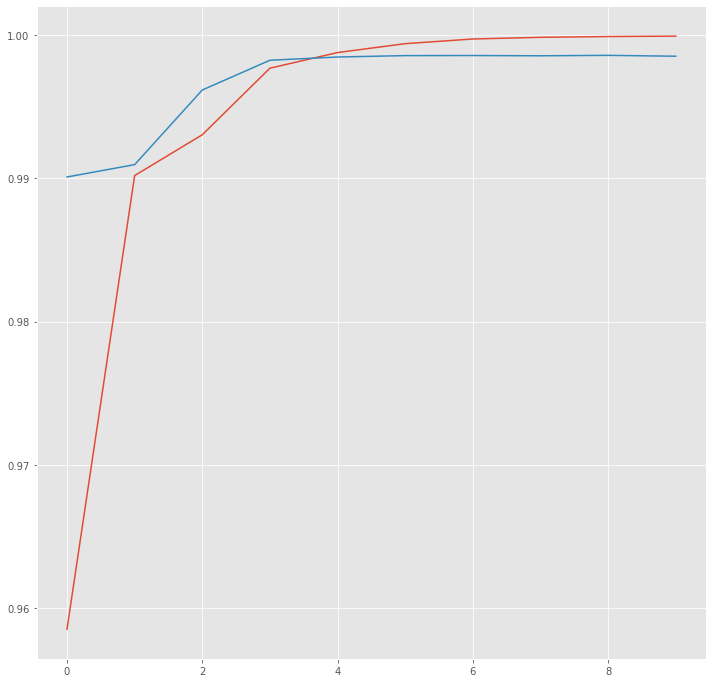

In [463]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()


In [464]:
y_pred = model.predict(X_te)

In [465]:
idx2tag = {i: w for w, i in tag2idx.items()}

In [466]:
i = 10
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], y_te[i], p):
    if t != 0: #PAD
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
RR             : object object
117/84         : object object
,pulss         : text  text
87             : text  text
Cor            : text  text
toonid         : text  text
arütmilised    : text  text
.              : text  text
jalgadel       : text  text
turseid        : text  text
ei             : text  text
ole            : text  text
.              : text  text
Kui            : text  text
RR             : object object
langeb         : text  object
väga           : text  text
madalale       : text  text
,              : text  text
siis           : text  text
võib           : text  text
mõned          : text  text
päevad         : text  text
ära            : text  text
jätta          : text  text
Raweli         : text  text


In [467]:
len(y_pred)

2729

### Wrong Tags


In [468]:
j = 0
for i in range(len(y_pred)):
    p = np.argmax(y_pred[i], axis=-1)
#     print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
#     print(30 * "=")
    for w, t, pred in zip(X_te[i], y_te[i], p):
        if idx2word[w] != "": #PAD
            if idx2tag[t] != idx2tag[pred]:
                print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))
                j = j+1


43,RR          : object text
puhtad.RR130/90: object text
langeb         : text  object
ebaregulaarne,fr.87/min.RR-125/100: object text
RR152/97mmHg   : object text
157            : object text
19.07.2011:    : text  PAD
RR108/72mmHg   : object text
p/s)RR-130/70mmHg.: object text
RR250.110mmhg, : object text
piim)RR-150/80mmHg.: object text
somnols        : text  object
KORRAS.        : object text
KOORMUSTEST-KORRAS: object text
RR119/73mmHg   : object text
155/95         : object text
Pikkus-174cm,  : object text
RR-100/54mmHg, : object text
RR108/74       : object text
RR156/92mmHg   : object text
Nõustamine.RR140/80: object text
RR125/80.71x   : object text
.RR134/95      : object text
suhtes.RR140/80mmhg: object text
kinnitatud_    : text  PAD
RR119/77mmHg   : object text
2.3.RR         : object text
kõikumised.RR  : object text
140-90mmhg     : object text
130/82         : object text
sööki.RR-136/74mmHG.: object text
/62            : text  object
2008.a.        : text  object
s

169cm          : text  object
RR135/86mmHg   : object text
RR-134/80mmHg. : object text
152/96         : text  object
RR136-78mmhg   : object text
Cor-akts.regul.fr.70x: text  object
RR141/81mmhg,  : object text
RR116-70mmhg,  : object text
RR-130/88mmHg, : object text
170cm          : object text
RR170/100mmHg  : object text
RR190-110      : object text
RR190-110      : object text
5.4,RR         : object text
155.95         : object text
fr.89x'        : text  object
Ps78,tehtud    : text  object
kaal-78,9(+1,0),: text  object
RR145/80mmHg   : object text
tervisetõend.RR-111/74: object text
,RR124/82      : object text
/>RR           : object text
120/70<br      : object text
RR102/74mmHg   : object text
RR160/94mmHg,fr.: object text
RR149/91mm/Hg  : object text
kontroll-      : text  object
Pikkus-165,    : object text
140/100        : text  object
2.3.RR         : object text
siidid         : text  object
13-101035-1    : object text
13-101035-1    : object text
13-101035-1    : ob

In [65]:
j

314

In [469]:
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "text"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PAD", "text"))
        out.append(out_i)
    return out

pred_labels = pred2label(y_pred)
test_labels = test2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))


F1-score: 83.7%
           precision    recall  f1-score   support

     text       0.87      0.82      0.85      4461
   object       0.89      0.76      0.82      2104

micro avg       0.88      0.80      0.84      6565
macro avg       0.88      0.80      0.84      6565



In [470]:
accuracy_score(test_labels, pred_labels)

0.9985244900451936

In [471]:
from sklearn_crfsuite.metrics import flat_classification_report,flat_accuracy_score
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)
print("Accuracy",flat_accuracy_score(y_pred=pred_labels, y_true=test_labels))

              precision    recall  f1-score   support

      object       0.95      0.88      0.91      3653
        text       1.00      1.00      1.00    405697

    accuracy                           1.00    409350
   macro avg       0.97      0.94      0.96    409350
weighted avg       1.00      1.00      1.00    409350

Accuracy 0.9985244900451936


## Interpretability
###### TextExplainer allows to explain predictions of black-box text classifiers using LIME algorithm.



In [472]:
from eli5.lime import TextExplainer
from eli5.lime.samplers import MaskingTextSampler
# https://eli5.readthedocs.io/en/latest/autodocs/lime.html

In [473]:
class NERExplainerGenerator(object):
    
    def __init__(self, model, word2idx, tag2idx, max_len):
        self.model = model
        self.word2idx = word2idx
        self.tag2idx = tag2idx
#         self.idx2tag = {v: k for k,v in tag2idx.items()}
        self.idx2tag = idx2tag
        self.max_len = max_len
        
    def _preprocess(self, texts):
        X = [[self.word2idx.get(w, self.word2idx["PAD"]) for w in t.split()]
             for t in texts]
        X = pad_sequences(maxlen=self.max_len, sequences=X,
                          padding="post", value=self.word2idx["PAD"],truncating="post")
        return X
    
    def get_predict_function(self, word_index):
        def predict_func(texts):
            X = self._preprocess(texts)
            p = self.model.predict(X)
            return p[:,word_index,:]
        return predict_func


In [474]:
Sentneceindex = 21
label = labels[20:24]
text = sentences[20:24]
# print(label)
# print(text)

text = " ".join(str(x) for x in text)
label = [' '.join(x) for x in label]
label = " ".join(str(x) for x in label)
# print(label)
# print(text)
# # # label = [' '.join(x) for x in label]
# label = " ".join(str(x) for x in label)

# print(label)
print(" ".join([f"{t} ({l})" for t, l in zip(text.split(), label.split())]))


Põhjendus: (text) 6A (text) dünaamikas (text) Kirjeldus: (text) Võrreldes (text) 23.10 (text) tehtud (text) ü/v-ga (text) dünaamika (text) puudub. (text) Pikkus-165, (object) kaal-107,6. (text) v/s-10,5 (text) tühjalt. (text) 29.04.2013 (text) - (text) RR (object) 120/80 (object) mmHg.fr.70 (text) x/min.O2 (text) saturatsioon (text) 100 (text) %,kaal (text) 63 (text) kg.pikkus (text) 168 (text) cm. (text) . (text) Cor (text) toonid (text) arütmilised. (text) Frekvents (text) 87x (text) minutis (text) .RR110/78 (object) mmhg (text) Turseid (text) ei (text) ole (text) . (text) Biokeemia (text) tehtud (text) perearsti (text) poolt (text) . (text)


In [475]:
for i, w in enumerate(text.split()):
    print(f"{i}: {w}")


0: Põhjendus:
1: 6A
2: dünaamikas
3: Kirjeldus:
4: Võrreldes
5: 23.10
6: tehtud
7: ü/v-ga
8: dünaamika
9: puudub.
10: Pikkus-165,
11: kaal-107,6.
12: v/s-10,5
13: tühjalt.
14: 29.04.2013
15: -
16: RR
17: 120/80
18: mmHg.fr.70
19: x/min.O2
20: saturatsioon
21: 100
22: %,kaal
23: 63
24: kg.pikkus
25: 168
26: cm.
27: .
28: Cor
29: toonid
30: arütmilised.
31: Frekvents
32: 87x
33: minutis
34: .RR110/78
35: mmhg
36: Turseid
37: ei
38: ole
39: .
40: Biokeemia
41: tehtud
42: perearsti
43: poolt
44: .


In [476]:
tag2idx

{'PAD': 0, 'text': 1, 'object': 2}

In [477]:
explainer_generator = NERExplainerGenerator(model, word2idx, tag2idx, max_len)


In [478]:
word_index = 17
predict_func = explainer_generator.get_predict_function(word_index=word_index)


In [479]:
sampler = MaskingTextSampler(
    replacement="UNK",
    max_replace=0.7,
    token_pattern=None,
    bow=False
)
print(sampler.sample_near(text, n_samples=10))


(('Põhjendus: 6A UNK Kirjeldus: Võrreldes 23.UNK tehtud ü/v-ga UNK puudub. Pikkus-165, UNK-107,UNK. UNK/s-10,5 UNK. 29.UNK.UNK - UNK 120/80 mmHg.fr.70 x/min.O2 saturatsioon 100 %,kaal 63 UNK.pikkus UNK UNK. . Cor toonid arütmilised. Frekvents 87x minutis .RR110/78 UNK Turseid UNK ole . Biokeemia UNK UNK poolt .', 'Põhjendus: 6A dünaamikas UNK: Võrreldes 23.10 tehtud UNK/v-ga UNK puudub. UNK-UNK, UNK-107,6. v/s-10,UNK UNK. 29.04.2013 - RR 120/80 mmHg.fr.70 x/min.O2 saturatsioon UNK %,kaal 63 kg.pikkus UNK cm. . UNK toonid arütmilised. Frekvents 87x UNK .RR110/78 mmhg Turseid ei ole . Biokeemia tehtud UNK poolt .', 'UNK: 6A dünaamikas Kirjeldus: Võrreldes 23.10 tehtud UNK/UNK-ga dünaamika UNK. UNK-165, kaal-107,UNK. v/s-10,5 tühjalt. 29.UNK.2013 - RR 120/80 mmHg.UNK.70 x/min.O2 saturatsioon 100 %,kaal UNK kg.pikkus 168 cm. . Cor toonid UNK. Frekvents 87x minutis .RR110/78 UNK Turseid ei ole . Biokeemia tehtud perearsti UNK .', 'Põhjendus: 6A dünaamikas UNK: Võrreldes 23.UNK tehtud ü/v-UN

In [480]:
idx2tag

{0: 'PAD', 1: 'text', 2: 'object'}

In [481]:
te = TextExplainer(
    sampler=sampler,
    position_dependent=True,
    random_state=42,
#     char_based =True #True if explanation should be char-based, False if it should be token-based. Default is False.
)

te.fit(text, predict_func)

te.explain_prediction(
    target_names=list(explainer_generator.idx2tag.values())
   
)
# https://github.com/TeamHG-Memex/eli5/blob/017c738f8dcf3e31346de49a390835ffafad3f1b/eli5/explain.py#L83


Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,\n              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n              power_t=0.5, random_state=RandomState(MT19937) at 0x1BB67004378,\n              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n              warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='PAD', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=59.5290399663065, std=None, value=1.0)], neg=[FeatureWeight(feature='[12] puudub', weight=-3.0929747829704284, std=None, value=1.0), FeatureWeight(feature='[27] 120', weight=-2.9690720462203295, std=None, value=1.0), FeatureWeight(feature='[28] 80', weight=-2.7774280534110076, std=None, value=1.0), FeatureWeight(feature='[14] 165', weight=-2.627764107449306, std=None, value=1.0), FeatureWeight(feature='[13] Pikkus', weight=-2.623422020079968, std=None, value=1.0), FeatureWeight(feature='[17] 6', weight=-2.2742384007466905, std=None, value=1.0), FeatureWeight(feature='[15] kaal', weight=-2.246713756655898, std=None, value=1.0), FeatureWeight(feature='[19] s', weight=-2.214755270763583, std=None, value=1.0), FeatureWeight(feature='[3] Kirjeldus', weight=-2.210268583775197, std=None, value=1.0), FeatureWeight(feature='[9] v', weight=-2.060443630560118, std=None, value=1.0), FeatureWeight(feature='[25] 2013', weight=-2.0504300703958043, std=None, value=1.0), FeatureWeight(feature='[22] tühjalt', weight=-2.011162580604892, std=None, value=1.0), FeatureWeight(feature='[21] 5', weight=-1.9973156571526027, std=None, value=1.0), FeatureWeight(feature='[18] v', weight=-1.9779174227341914, std=None, value=1.0), FeatureWeight(feature='[26] RR', weight=-1.9510795124955338, std=None, value=1.0), FeatureWeight(feature='[20] 10', weight=-1.9448878440226554, std=None, value=1.0), FeatureWeight(feature='[23] 29', weight=-1.8438243906175458, std=None, value=1.0), FeatureWeight(feature='[6] 10', weight=-1.8372983181257965, std=None, value=1.0), FeatureWeight(feature='[0] Põhjendus', weight=-1.798729420377936, std=None, value=1.0), FeatureWeight(feature='[16] 107', weight=-1.7689022757971502, std=None, value=1.0), FeatureWeight(feature='[24] 04', weight=-1.7088287411063772, std=None, value=1.0), FeatureWeight(feature='[10] ga', weight=-1.6823941932678115, std=None, value=1.0), FeatureWeight(feature='[5] 23', weight=-1.669722019520153, std=None, value=1.0), FeatureWeight(feature='[8] ü', weight=-1.432713722529107, std=None, value=1.0), FeatureWeight(feature='[30] fr', weight=-1.0152650879167189, std=None, value=1.0), FeatureWeight(feature='[29] mmHg', weight=-0.915116617987036, std=None, value=1.0), FeatureWeight(feature='[31] 70', weight=-0.7742013039126702, std=None, value=1.0), FeatureWeight(feature='[40] pikkus', weight=-0.7387497452820333, std=None, value=1.0), FeatureWeight(feature='[33] min', weight=-0.7039735964526163, std=None, value=1.0), FeatureWeight(feature='[11] dünaamika', weight=-0.6964318669228834, std=None, value=1.0), FeatureWeight(feature='[53] ei', weight=-0.6655128096866921, std=None, value=1.0), FeatureWeight(feature='[32] x', weight=-0.6378706387526315, std=None, value=1.0), FeatureWeight(feature='[55] Biokeemia', weight=-0.5951403044224269, std=None, value=1.0), FeatureWeight(feature='[7] tehtud', weight=-0.5830362801213819, std=None, value=1.0), FeatureWeight(feature='[34] O2', weight=-0.5775018039727202, std=None, value=1.0), FeatureWeight(feature='[35] saturatsioon', weight=-0.5734088524493463, std=None, value=1.0), FeatureWeight(feature='[2] dünaamikas', weight=-0.5489635620784274, std=None, value=1.0), FeatureWeight(feature='[49] RR110', weight=-0.5008995736651467, std=None, value=1.0), FeatureWeight(feature='[38] 63', weight=-0.500714

In [482]:
label = labels[196:201]
text = sentences[196:201]
text = " ".join(str(x) for x in text)
label = [' '.join(x) for x in label]
label = " ".join(str(x) for x in label)
print(text)
print(" ".join([f"{t} ({l})" for t, l in zip(text.split(), label.split())]))


Üldseisund: rahuldav 156 cm,90 kg Kardiovaskulaarsüsteem: RR 140/80 mmHg,fr reg 72 x min RR130/100 mmHg. Obj. liigesturset ei ole, k.a. MTP-des. RR 160/80 mmHg, kaal 131,1 kg, eutüreoidne, kilpnääre palp.tundub veidi tihedam normist, võimalik nodoosne.
Üldseisund: (text) rahuldav (text) 156 (text) cm,90 (text) kg (text) Kardiovaskulaarsüsteem: (text) RR (object) 140/80 (object) mmHg,fr (text) reg (text) 72 (text) x (text) min (text) RR130/100 (object) mmHg. (text) Obj. (text) liigesturset (text) ei (text) ole, (text) k.a. (text) MTP-des. (text) RR (object) 160/80 (object) mmHg, (text) kaal (text) 131,1 (text) kg, (text) eutüreoidne, (text) kilpnääre (text) palp.tundub (text) veidi (text) tihedam (text) normist, (text) võimalik (text) nodoosne. (text)


In [483]:
for i, w in enumerate(text.split()):
    print(f"{i}: {w}")

0: Üldseisund:
1: rahuldav
2: 156
3: cm,90
4: kg
5: Kardiovaskulaarsüsteem:
6: RR
7: 140/80
8: mmHg,fr
9: reg
10: 72
11: x
12: min
13: RR130/100
14: mmHg.
15: Obj.
16: liigesturset
17: ei
18: ole,
19: k.a.
20: MTP-des.
21: RR
22: 160/80
23: mmHg,
24: kaal
25: 131,1
26: kg,
27: eutüreoidne,
28: kilpnääre
29: palp.tundub
30: veidi
31: tihedam
32: normist,
33: võimalik
34: nodoosne.


In [484]:
word_index = 6
predict_func = explainer_generator.get_predict_function(word_index=word_index)
te = TextExplainer(
    random_state=1,
)

te.fit(text, predict_func)

te.explain_prediction(
    target_names=list(explainer_generator.idx2tag.values())
   
)

Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,\n              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n              power_t=0.5, random_state=RandomState(MT19937) at 0x1BB04A79E18,\n              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n              warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='PAD', feature_weights=FeatureWeights(pos=[], neg=[FeatureWeight(feature='mmhg', weight=-1.916945848190337, std=None, value=3.0), FeatureWeight(feature='80', weight=-1.1649379964407964, std=None, value=2.0), FeatureWeight(feature='rr', weight=-1.160585429117997, std=None, value=2.0), FeatureWeight(feature='kg', weight=-1.1080102952727826, std=None, value=2.0), FeatureWeight(feature='normist', weight=-0.492240487056584, std=None, value=1.0), FeatureWeight(feature='tihedam', weight=-0.47387936630545463, std=None, value=1.0), FeatureWeight(feature='cm', weight=-0.45197698303532297, std=None, value=1.0), FeatureWeight(feature='131', weight=-0.43900114770911497, std=None, value=1.0), FeatureWeight(feature='nodoosne', weight=-0.43527591377219005, std=None, value=1.0), FeatureWeight(feature='rahuldav', weight=-0.4339675083168437, std=None, value=1.0), FeatureWeight(feature='rr130', weight=-0.4304884255502668, std=None, value=1.0), FeatureWeight(feature='100', weight=-0.42443503787650627, std=None, value=1.0), FeatureWeight(feature='72', weight=-0.4166744737487394, std=None, value=1.0), FeatureWeight(feature='160', weight=-0.41447568532029827, std=None, value=1.0), FeatureWeight(feature='liigesturset', weight=-0.4124679377878878, std=None, value=1.0), FeatureWeight(feature='veidi', weight=-0.4111714423211451, std=None, value=1.0), FeatureWeight(feature='a', weight=-0.40705003263470346, std=None, value=1.0), FeatureWeight(feature='kaal', weight=-0.40134413160004906, std=None, value=1.0), FeatureWeight(feature='1', weight=-0.3999566612254949, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=-0.39693123237086303, std=None, value=1.0), FeatureWeight(feature='tundub', weight=-0.3949227003099838, std=None, value=1.0), FeatureWeight(feature='reg', weight=-0.3910252150707444, std=None, value=1.0), FeatureWeight(feature='üldseisund', weight=-0.3838597688866995, std=None, value=1.0), FeatureWeight(feature='des', weight=-0.37813388682430826, std=None, value=1.0), FeatureWeight(feature='156', weight=-0.37680734462850585, std=None, value=1.0), FeatureWeight(feature='ei', weight=-0.3755909937260587, std=None, value=1.0), FeatureWeight(feature='ole', weight=-0.37529853299959226, std=None, value=1.0), FeatureWeight(feature='mtp', weight=-0.3684109457484815, std=None, value=1.0), FeatureWeight(feature='eutüreoidne', weight=-0.36672668866228325, std=None, value=1.0), FeatureWeight(feature='140', weight=-0.35866789259696474, std=None, value=1.0), FeatureWeight(feature='võimalik', weight=-0.3496211678374671, std=None, value=1.0), FeatureWeight(feature='k', weight=-0.3476996636497224, std=None, value=1.0), FeatureWeight(feature='palp', weight=-0.33183590819037795, std=None, value=1.0), FeatureWeight(feature='x', weight=-0.3305293187899821, std=None, value=1.0), FeatureWeight(feature='min', weight=-0.3231985724019116, std=None, value=1.0), FeatureWeight(feature='obj', weight=-0.31710649169861627, std=None, value=1.0), FeatureWeight(feature='90', weight=-0.31534140672367533, std=None, value=1.0), FeatureWeight(feature='kardiovaskulaarsüsteem', weight=-0.3008791768372755, std=None, value=1.0), FeatureWeight(feature='kilpnääre', weight=-0.29888520920593054, std=None, value=1.0), FeatureWeight(feature='fr', weight=-0.24638026998255363, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=4.955225347479425e-09, score=-19.12273719042451

In [485]:
sampler = MaskingTextSampler(
    replacement="UNK",
    max_replace=0.2,
    token_pattern=None,
    bow=False
)
print(sampler.sample_near(text, n_samples=5))


(('Üldseisund: rahuldav 156 cm,90 kg Kardiovaskulaarsüsteem: RR 140/80 mmHg,UNK reg 72 x min RR130/100 mmHg. Obj. liigesturset ei ole, k.a. MTP-des. RR 160/80 mmHg, kaal 131,1 kg, eutüreoidne, kilpnääre palp.tundub veidi tihedam normist, võimalik nodoosne.', 'UNK: rahuldav 156 cm,90 kg Kardiovaskulaarsüsteem: RR 140/80 mmHg,fr reg 72 x UNK RR130/100 mmHg. UNK. liigesturset ei ole, k.a. MTP-des. RR 160/80 UNK, kaal 131,1 kg, eutüreoidne, kilpnääre palp.tundub UNK tihedam normist, võimalik UNK.', 'Üldseisund: rahuldav 156 cm,90 kg Kardiovaskulaarsüsteem: RR 140/80 mmHg,fr reg 72 x min RR130/100 mmHg. Obj. liigesturset UNK ole, k.a. MTP-des. RR 160/80 mmHg, kaal 131,1 kg, UNK, kilpnääre palp.UNK veidi tihedam normist, võimalik nodoosne.', 'Üldseisund: rahuldav 156 UNK,90 kg Kardiovaskulaarsüsteem: RR 140/80 mmHg,fr reg 72 x min RR130/100 mmHg. UNK. liigesturset ei ole, k.a. MTP-des. RR 160/UNK mmHg, kaal 131,1 kg, eutüreoidne, kilpnääre palp.tundub veidi tihedam normist, võimalik nodoosne

In [486]:
label = labels[105:109]
text = sentences[105:109]
text = " ".join(str(x) for x in text)
label = [' '.join(x) for x in label]
label = " ".join(str(x) for x in label)
print(text)
print(" ".join([f"{t} ({l})" for t, l in zip(text.split(), label.split())]))

for i, w in enumerate(text.split()):
    print(f"{i}: {w}")
    
word_index =16
predict_func = explainer_generator.get_predict_function(word_index=word_index)

te = TextExplainer(
    sampler=sampler,
    position_dependent=True,
    random_state=1,
#     char_based =True #True if explanation should be char-based, False if it should be token-based. Default is False.
)

te.fit(text, predict_func)

te.explain_prediction(
    target_names=list(explainer_generator.idx2tag.values())
   
)

Cor toonid regulaarsed . kerge süstoolne kahin . EKG regulaarne siinusrütm . Vasema vatsakese hüpertroofia . RR 150/ 90 27.06.2012 - KMI 38,77, kaal 127 kg. RR 150/100 mmHg. Kilpnääre II astmes, sõlmedega, kahinata, valutu. Jalgadel laienenud kapillaarid. . 02.02.2012 - Kaal 98kg RR 120/80mmHg Cor regul 64xmin. perif turseid ei ole. Abdominaalne rasvumine. TSH 1,34. . 29.08.2012:
Cor (text) toonid (text) regulaarsed (text) . (text) kerge (text) süstoolne (text) kahin (text) . (text) EKG (text) regulaarne (text) siinusrütm (text) . (text) Vasema (text) vatsakese (text) hüpertroofia (text) . (text) RR (object) 150/ (object) 90 (text) 27.06.2012 (text) - (text) KMI (text) 38,77, (text) kaal (text) 127 (text) kg. (text) RR (object) 150/100 (object) mmHg. (text) Kilpnääre (text) II (text) astmes, (text) sõlmedega, (text) kahinata, (text) valutu. (text) Jalgadel (text) laienenud (text) kapillaarid. (text) . (text) 02.02.2012 (text) - (text) Kaal (text) 98kg (text) RR (object) 120/80mmHg (obj

Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,\n              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n              power_t=0.5, random_state=RandomState(MT19937) at 0x1BB731FF8C8,\n              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n              warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='PAD', feature_weights=FeatureWeights(pos=[], neg=[FeatureWeight(feature='<BIAS>', weight=-3.7973660188787095, std=None, value=1.0), FeatureWeight(feature='[1] toonid', weight=-0.13257439584884356, std=None, value=1.0), FeatureWeight(feature='[22] 127', weight=-0.1324635571475264, std=None, value=1.0), FeatureWeight(feature='[14] 90', weight=-0.1134026699610312, std=None, value=1.0), FeatureWeight(feature='[26] 100', weight=-0.10917668737881446, std=None, value=1.0), FeatureWeight(feature='[21] kaal', weight=-0.10872219951601375, std=None, value=1.0), FeatureWeight(feature='[54] TSH', weight=-0.10820670152325124, std=None, value=1.0), FeatureWeight(feature='[10] vatsakese', weight=-0.10770037222041366, std=None, value=1.0), FeatureWeight(feature='[23] kg', weight=-0.10737282543703637, std=None, value=1.0), FeatureWeight(feature='[52] Abdominaalne', weight=-0.10610604144285667, std=None, value=1.0), FeatureWeight(feature='[11] hüpertroofia', weight=-0.10573082435911793, std=None, value=1.0), FeatureWeight(feature='[29] II', weight=-0.10550400049921424, std=None, value=1.0), FeatureWeight(feature='[32] kahinata', weight=-0.1043091906686059, std=None, value=1.0), FeatureWeight(feature='[15] 27', weight=-0.10335757994321543, std=None, value=1.0), FeatureWeight(feature='[6] EKG', weight=-0.1022874694163975, std=None, value=1.0), FeatureWeight(feature='[30] astmes', weight=-0.10222039861030717, std=None, value=1.0), FeatureWeight(feature='[25] 150', weight=-0.08061936709996444, std=None, value=1.0), FeatureWeight(feature='[58] 08', weight=-0.07896093941165247, std=None, value=1.0), FeatureWeight(feature='[20] 77', weight=-0.07843138112396048, std=None, value=1.0), FeatureWeight(feature='[41] 98kg', weight=-0.07813531787901723, std=None, value=1.0), FeatureWeight(feature='[57] 29', weight=-0.0774621521259673, std=None, value=1.0), FeatureWeight(feature='[24] RR', weight=-0.07726123417348521, std=None, value=1.0), FeatureWeight(feature='[45] Cor', weight=-0.07709050991372017, std=None, value=1.0), FeatureWeight(feature='[27] mmHg', weight=-0.07701662081349377, std=None, value=1.0), FeatureWeight(feature='[19] 38', weight=-0.07693384634819822, std=None, value=1.0), FeatureWeight(feature='[9] Vasema', weight=-0.07690655212262328, std=None, value=1.0), FeatureWeight(feature='[0] Cor', weight=-0.07683777249135566, std=None, value=1.0), FeatureWeight(feature='[44] 80mmHg', weight=-0.0767428742060874, std=None, value=1.0), FeatureWeight(feature='[8] siinusrütm', weight=-0.07661834368803402, std=None, value=1.0), FeatureWeight(feature='[49] turseid', weight=-0.0765811584018752, std=None, value=1.0), FeatureWeight(feature='[7] regulaarne', weight=-0.07640405281925298, std=None, value=1.0), FeatureWeight(feature='[35] laienenud', weight=-0.07629705653592322, std=None, value=1.0), FeatureWeight(feature='[16] 06', weight=-0.07625386217715041, std=None, value=1.0), FeatureWeight(feature='[42] RR', weight=-0.0761916111916762, std=None, value=1.0), FeatureWeight(feature='[38] 02', weight=-0.0759839873662624, std=None, value=1.0), FeatureWeight(feature='[46] regul', weight=-0.07593203152761306, std=None, value=1.0), FeatureWeight(feature='[55] 1', weight=-0.0757072849465541, std=None, value=1.0), FeatureWeight(feature='[39] 2012', weight=-0.07567973664915911, std=None, value=1.0), FeatureWeight(feature='[17] 2012', weight=-0.0755591252237243, std

In [487]:
te.metrics_


{'mean_KL_divergence': 0.01325315504867729, 'score': 1.0}

In [488]:
te.clf

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=RandomState(MT19937) at 0x1BB79BE7048,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [489]:
te.vec_

SingleDocumentVectorizer(token_pattern='(?u)\\b\\w+\\b')

#### In this example both accuracy and KL divergence are good; it means our white-box classifier usually assigns the same labels as the black-box classifier on the dataset we generated, and its predicted probabilities are close to those predicted by our NN model. So it is likelythat the explanation is correct and can be trusted.